In [2]:
from __future__ import division, print_function

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.ma as ma
import scipy.io as sio
import scipy.linalg
import matplotlib.colors as colors
from scipy import signal
from scipy.fftpack import fft
from geopy.distance import vincenty
import math

#from mpl_toolkits.basemap import Basemap
# from salishsea_tools import viz_tools

%matplotlib inline

In [3]:
# s_bathy = sio.loadmat('/ocean/jthibaul/research/data/SANDWELL_TOPOG_16.1/SS_BATHY.mat', 
#                        struct_as_record=False, squeeze_me=True)
# s_vlon = sio.loadmat('/ocean/jthibaul/research/data/SANDWELL_TOPOG_16.1/SS_vLON.mat', 
#                        struct_as_record=False, squeeze_me=True)
# s_vlat = sio.loadmat('/ocean/jthibaul/research/data/SANDWELL_TOPOG_16.1/SS_vLAT.mat', 
#                        struct_as_record=False, squeeze_me=True)
s_bathy = sio.loadmat('/home/jacquielee/data/SS_BATHY.mat', 
                       struct_as_record=False, squeeze_me=True)
s_vlon = sio.loadmat('/home/jacquielee/data/SS_vLON.mat', 
                       struct_as_record=False, squeeze_me=True)
s_vlat = sio.loadmat('/home/jacquielee/data/SS_vLAT.mat', 
                       struct_as_record=False, squeeze_me=True)

bathy = s_bathy['image_data'][:,3500:15000]
lon = s_vlon['vlon'][3500:15000]
lat = s_vlat['vlat']


In [3]:
print(bathy.shape,lon.shape,lat.shape)

(7256, 11500) (11500,) (7256,)


In [4]:
bathy0 = np.ma.masked_where(bathy[:,:] > 0.0,bathy)

In [11]:
lat[-1]

64.0005960328931

In [12]:
type(lon)

numpy.ndarray

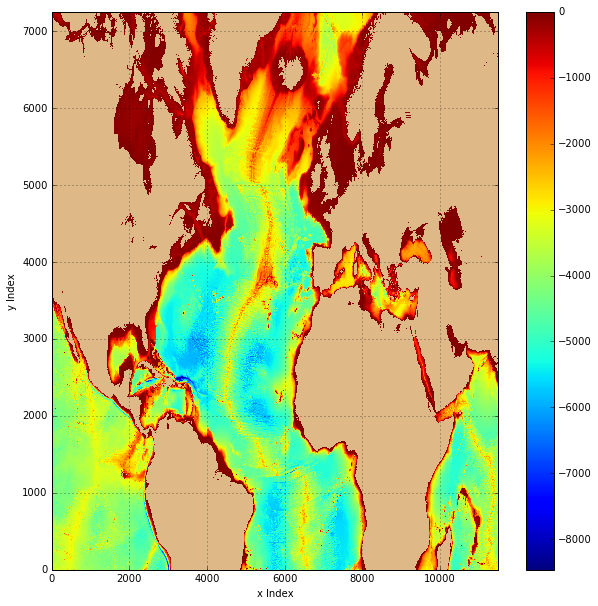

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
x_lon, y_lat = np.meshgrid(lon[:], lat[:])
mesh = ax.pcolormesh(bathy0,cmap=cmap)
cbar = fig.colorbar(mesh,ax=ax)
plt.axis((0, bathy0.shape[1], 0, bathy0.shape[0]))
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [9]:
def h_2(i,j,bathy,ibcaox,ibcaoy):
    #i,j are the gridpoints that hsquare will be calculated for. 
    # bathy, ibcaox, and ibcaoy are the IBCAO variables from the arcsec file
    if ma.is_masked(bathy[i,j]):
        # If the grid point is masked - return masked element
        return -1.0
    data = data_grid(bathy,i,j,ibcaox,ibcaoy)
    if np.isnan(data).any():
        # If any bathy values are masked then delete the rows with the masked 
        # element before plane fitting.
        count = len(data[:,0])
        row = 0
        while row < count:
            if np.isnan(data[row,2]):
                data = np.delete(data, (row), axis=0)
                count = count-1
            else:
                row = row + 1
    C = coeff(data,i,j)
    h = 0
    for index in np.arange(0,len(data[:,0])):
        distance = (data[index,2] - (C[0]*data[index,0] + C[1]*data[index,1] + C[2]))**2
        h = h + distance
    hsquare = h/len(data[:,0])
    return hsquare

def data_grid(bathy,i,j,ibcaox,ibcaoy):
    x,y = x_y(i,j,ibcaox,ibcaoy)
    gridz = zgrid(bathy,i,j)
    d = np.array([[y[0],x[0],gridz[2,0]],
               [y[1],x[0],gridz[2,1]],
               [y[2],x[0],gridz[2,2]],
               [y[0],x[1],gridz[1,0]],
               [y[0],x[2],gridz[0,0]],
               [y[1],x[1],gridz[1,1]],
               [y[1],x[2],gridz[0,1]],
               [y[2],x[1],gridz[1,2]],
               [y[2],x[2],gridz[0,2]]])
    return d

def zgrid(bathy,i,j):
    #creates a grid of bathemitric values for the surrounding cells
    gridz = np.array([[bathy[i-1,j+1],bathy[i,j+1],bathy[i+1,j+1]]
                     ,[bathy[i-1,j  ],bathy[i,j  ],bathy[i+1,j  ]]
                     ,[bathy[i-1,j-1],bathy[i,j-1],bathy[i+1,j-1]]])
    return gridz

def grid_dist(x_lon, y_lat, x_dist, y_dist):
    start = (y_lat[0],x_lon[0])
    for d in np.arange(1,len(y_lat)):
        endy = (y_lat[d],x_lon[0])
        y_dist[d] = vincenty(start,endy).meters
    for d in np.arange(1,len(x_lon)):
        endx = (y_lat[0],x_lon[d])
        x_dist[d] = vincenty(start,endx).meters
    return x_dist, y_dist

def x_y(i,j,ibcaox,ibcaoy):
    x_lon = np.array([ibcaox[j-1],ibcaox[j],ibcaox[j+1]])
    y_lat = np.array([ibcaoy[i-1],ibcaoy[i],ibcaoy[i+1]])

    x_dist = np.zeros_like(x_lon)
    y_dist = np.zeros_like(y_lat)
    
    x , y = grid_dist(x_lon, y_lat, x_dist, y_dist)
    return x, y

def coeff(data,i,j,order=1):
    if order == 1:
        # best-fit linear plane
        A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients

    elif order == 2:
        # best-fit quadratic curve
        A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
     
    return C

In [11]:
hsquare = np.zeros_like(bathy,dtype=float)

i = np.arange(0,len(lat)-1)
j = np.arange(0,len(lon)-1)
# print(h_2(311,1,bathy0,lon,lat))
for ii in i:
    for jj in j:
        h = h_2(ii,jj,bathy0,lon,lat)

        hsquare[ii,jj] = h
#save numpy array
hsquare.dump('hsquare_sandwell.npy')



In [12]:
hsquare1 = np.ma.masked_where(hsquare[:,:] < -0.1,hsquare)
#hsquare1.dump('hsquare_sandwell.npy')

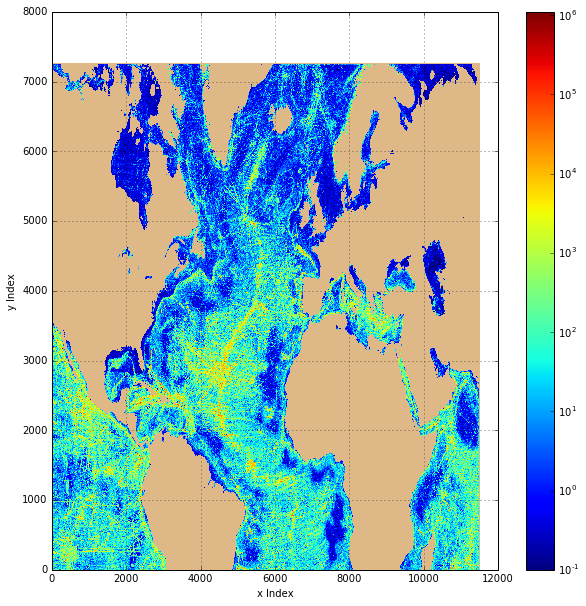

In [4]:
hsquare = np.load('/mnt/storage0/jacquielee/data/hsquare_sandwell.npy')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
#x_lon, y_lat = np.meshgrid(lon[:], lat[:])
mesh = ax.pcolormesh(hsquare[:,:],cmap=cmap,norm=colors.LogNorm(vmin=0.1, vmax=hsquare.max()))
cbar = fig.colorbar(mesh,ax=ax)
#plt.axis((0, hsquare[:10,:10].shape[1], 0, hsquare[:10,:10].shape[0]))
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [6]:
hsquare = ma.masked_where(hsquare == -1.0,hsquare)

In [5]:
hsquare.min()

-1.0